In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, _safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

# Set folder paths for outputs


In [2]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'ccard')

In [3]:
os.chdir('..')
PATH_1 = Path(os.getcwd())
os.chdir('..')
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier')

In [4]:
from Mixed_Distances.distMix import distmix
from scipy.spatial.distance import cdist
from Sampling_Methods.Balance import BalanceDataset
from Sampling_Methods.Sampling_Study.auxSamplingStudy import *

In [5]:
os.chdir(PATH_1)
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier/Sampling_Methods')

# Read the file

In [6]:
df= pd.read_csv(DATA / 'credit_card.csv')

### Three columns  are removed from this file- clientnum, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 and Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2

In [7]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [8]:
df.rename(columns = {'Attrition_Flag': 'target'},inplace = True)

In [9]:
df.target.unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

#### In order to feed the data to any machine learning method, it's convenient to change strings to numeric values. So, we are going to change 'Existing' to 0 and 'Attrited' to 1

In [10]:
df['target'].replace({'Existing Customer': 0, 'Attrited Customer' : 1},inplace = True)


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.isnull().sum()

target                      0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [13]:
df.shape

(10127, 20)

# Remove unknown observations

In [14]:
for cols in ['Education_Level', 'Marital_Status', 'Income_Category']:
    df = df.loc[~df[cols].isin(['Unknown', 'unknown'])]


In [15]:
Counter(df.target)

Counter({0: 5968, 1: 1113})

In [16]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [17]:
df.shape

(7081, 20)

In [18]:
df_t1 = df.loc[df['target'] == 1].head(500)
df_t2 = df.loc[df['target'] == 0]
df = df_t1.append(df_t2)

In [19]:
df.shape

(6468, 20)

# Create helper functions

In [20]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [4, 5, 6], 'max_features': [3, 5],
'min_samples_leaf': [2, 3], 'min_samples_split': [4, 5], 'n_estimators': [500]
}
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [21]:
## Replace Male with 0 and Female with 1
df['Gender'].replace({'M': 0, 'F': 1},inplace = True)

In [22]:
Counter(df.target)

Counter({1: 500, 0: 5968})

# Num of minority instances is 500 and majority instances is 5968

In [23]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [24]:
# df_feature= df.drop(['target'],1)
# df_target= df[['target']]

In [25]:
df.columns

Index(['target', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [26]:
encoded_df = MultiColumnLabelEncoder(columns = ['Education_Level', 'Marital_Status', 
                                                'Income_Category', 'Card_Category']).fit_transform(df)


In [27]:
## Check if categorical variables and the target has some correlation

anovap_value = list()
for cols in ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    statistic, p = stats.f_oneway(encoded_df[cols], encoded_df['target'])
    anovap_value.append(tuple([cols, p]))
    
print(anovap_value)

[('Gender', 0.0), ('Education_Level', 0.0), ('Marital_Status', 0.0), ('Income_Category', 0.0), ('Card_Category', 9.292702718255405e-29)]


In [28]:
from scipy.stats import chi2_contingency
chi2p_value = list()
for cols in ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    obs = pd.crosstab(encoded_df[cols], encoded_df['target'])
    g, p, dof, expctd = chi2_contingency(obs)
    chi2p_value.append(tuple([cols, p]))
    
print(chi2p_value)

[('Gender', 0.058843486727238416), ('Education_Level', 0.04097165799983772), ('Marital_Status', 0.12227261153702998), ('Income_Category', 0.23228068911971203), ('Card_Category', 0.5613422371115784)]


In [29]:
encoded_df= encoded_df.drop(['target'],1)
df_target= df[['target']]

In [30]:
1- 2000 / encoded_df.shape[0]

0.6907854050711193

In [31]:
np.sum(df_target)/df_target.shape[0]

target    0.077304
dtype: float64

In [32]:
#Sampling: Added by me
encoded_df, aux1, df_target, aux2 = train_test_split(encoded_df, df_target, test_size=0.70, random_state=12)

In [33]:
df_target.shape

(1940, 1)

In [34]:
np.sum(df_target)

target    160
dtype: int64

In [35]:
np.sum(df_target)/df_target.shape[0]

target    0.082474
dtype: float64

In [36]:
1/12

0.08333333333333333

In [37]:
# Split the raw data into train and test set. Split ratio = 75:25
X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [38]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [39]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

columns = [0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
name_columns = X_train.columns[columns]

sc = StandardScaler()
X_train[name_columns] = sc.fit_transform(X_train[name_columns])
X_test[name_columns] = sc.transform(X_test[name_columns])

In [40]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [41]:
X_train

Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
0         2.344565       0        -1.026149                2               2   
1         1.224869       0        -1.026149                5               1   
2         2.344565       1        -1.794177                3               1   
3        -0.268060       0         2.045964                2               2   
4        -1.387757       1         0.509907                2               1   
...            ...     ...              ...              ...             ...   
1450      1.598101       1        -1.794177                0               1   
1451     -1.138935       0        -0.258121                1               2   
1452      1.598101       0        -1.794177                3               2   
1453      1.846922       0        -1.794177                5               1   
1454     -0.890114       0         0.509907                0               2   

      Income_Category  Card_Category  Months_on_book  \
0                   4              0        2.546651   
1                   0              0        0.016865   
2                   4              0        0.016865   
3                   2              0       -0.236113   
4                   4              0       -1.880474   
...               ...            ...             ...   
1450                1              0        2.167183   
1451                0              0       -0.489092   
1452                4              0        1.028779   
1453                3              0        0.902290   
1454                0              0       -0.742070   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                     0.715703                0.666684              -0.360507   
1                    -0.611700               -0.311164              -0.360507   
2                    -0.611700               -0.311164              -0.360507   
3                    -0.611700                0.666684               2.315703   
4                    -0.611700               -1.289013              -1.252576   
...                        ...                     ...                    ...   
1450                 -0.611700               -0.311164              -2.144646   
1451                 -0.611700                0.666684               2.315703   
1452                 -1.275401               -1.289013              -1.252576   
1453                 -0.611700                0.666684               2.315703   
1454                  0.052001               -0.311164              -1.252576   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0        -0.080737            -1.515926         0.055699   
1        -0.261029             0.184705        -0.277206   
2        -0.627604             0.750746        -0.694072   
3         0.579505             1.065770         0.482722   
4        -0.687061            -0.757859        -0.617786   
...            ...                  ...              ...   
1450     -0.781299            -1.515926        -0.643708   
1451      2.679596             0.852407         2.598535   
1452     -0.515472            -0.073841        -0.507984   
1453     -0.781299            -1.515926        -0.643708   
1454      0.055584            -1.515926         0.191796   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                 0.158542        -0.144787        0.062815   
1                -0.374607        -0.771755       -0.706294   
2                -0.006918        -0.831718       -1.304490   
3                -0.379203        -0.148902        0.062815   
4                 1.013420         0.070962        0.404641   
...                    ...              ...             ...   
1450              0.595173         0.024814        0.575554   
1451              0.296426        -0.482815        0.105543   
1452             -0.779065         0.024226        0.831924   
1453             -0.305665        -0.709734     

In [42]:
X_train
nbinsA = calculate_nbins(X_train, [1, 3, 4, 5, 6], "average")
nbinsFD = calculate_nbins(X_train, [0, 2, 7, 8, 9, 10, 11,12,13,14,15,16,17,18], "FD")
print(nbinsA)
print(nbinsFD)

[2, 6, 3, 5, 3]
[24.20821911181842, 14.16438352287248, 27.06971073260074, 14.164383522872475, 33.99452045489395, 33.99452045489395, 23.10851930231906, 12.454760987622716, 24.451863073622988, 61.2625756751818, 35.48309840377391, 20.496696156627234, 85.47472815526497, 11.366019021805487]
3
24


In [43]:
## Apply the random-forest classifier along with the NEW SMOTE method
filename = (MODELS / 'ccard_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [1, 3, 4, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = 1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.0s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.1s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.1s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=  

In [44]:
## Apply the random-forest classifier along with the NEW SMOTE method

dict_methods = {"gower": {"method": "gower", "weigths_boolean": False, "nbins":3},
                "huang": {"method": "huang", "weigths_boolean": False, "nbins":3},
                "ahmadA": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadFD": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadL1A": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadL1FD": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsFD}
                }    

methods_saved = []

for name, dict_info in dict_methods.items():

    filename = (MODELS / f'ccard_rsmotenc_{name}.sav')
    samp_pipeline = make_pipeline(BalanceDataset(cat_vars = X_train.columns[[1, 3, 4, 5, 6]], method=dict_info["method"], weigths_boolean = dict_info["weigths_boolean"], nbins=dict_info["nbins"]), 
                                RandomForestClassifier(random_state=42))
    # check model performance on different values of hyper-parameters.
    grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                            return_train_score=True, n_jobs = 1, verbose = 2)
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    pickle.dump(best_grid, open(filename, 'wb'))

    methods_saved.append(name)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
(1164, 19)
(92, 19)
[[0.         0.29016194 0.33809156 ... 0.29640859 0.35325073 0.27066633]
 [0.29016194 0.         0.22983807 ... 0.28782161 0.31502846 0.29614587]
 [0.33809156 0.22983807 0.         ... 0.19684863 0.34182547 0.24626514]
 ...
 [0.29640859 0.28782161 0.19684863 ... 0.         0.39641627 0.17387576]
 

In [45]:
methods_saved

['gower', 'huang', 'ahmadA', 'ahmadFD', 'ahmadL1A', 'ahmadL1FD']

In [46]:
## Apply the random-forest classifier along with the existing SMOTE method
filename = (MODELS / 'ccard_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [1, 3, 4, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=4, randomfore

/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.1s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.6s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.7s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.7s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.7s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.7s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.7s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=4, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.1s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.1s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.1s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.1s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   1.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.6s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.8s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.1s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.8s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.0s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   3.3s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   3.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   3.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   3.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   3.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.1s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.2s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.0s
[CV] END randomforestclassifier__max_depth=6, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   3.0s
[CV] END randomforestclassifier__max_depth=6, randomfore

In [80]:
## Evaluate SMOTE-NC performance on train and test set

filename = (MODELS / 'ccard_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.65
Predicted  False  True
Actual                
0           1314    27
1             28    86
              precision    recall  f1-score   support

           0     0.9791    0.9799    0.9795      1341
           1     0.7611    0.7544    0.7577       114

    accuracy                         0.9622      1455
   macro avg     0.8701    0.8671    0.8686      1455
weighted avg     0.9620    0.9622    0.9621      1455

Best Threshold:  0.5
Predicted  False  True
Actual                
0            408    31
1             11    35
              precision    recall  f1-score   support

           0     0.9737    0.9294    0.9510       439
           1     0.5303    0.7609    0.6250        46

    accuracy                         0.9134       485
   macro avg     0.7520    0.8451    0.7880       485
weighted avg     0.9317    0.9134    0.9201       485



array([0.01472334, 0.00790737, 0.00776791, 0.00916187, 0.00141462,
       0.07695215, 0.00104008, 0.00905759, 0.02323402, 0.07136218,
       0.03357237, 0.01452947, 0.13353192, 0.01776502, 0.05683688,
       0.17533866, 0.20971612, 0.09115256, 0.04493588])

In [81]:
## Evaluate SMOTE-ENC performance on train and test  set
import sklearn.ensemble._forest

filename = (MODELS / 'ccard_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.7000000000000001
Predicted  False  True
Actual                
0           1324    17
1             40    74
              precision    recall  f1-score   support

           0     0.9707    0.9873    0.9789      1341
           1     0.8132    0.6491    0.7220       114

    accuracy                         0.9608      1455
   macro avg     0.8919    0.8182    0.8504      1455
weighted avg     0.9583    0.9608    0.9588      1455

Best Threshold:  0.55
Predicted  False  True
Actual                
0            412    27
1             12    34
              precision    recall  f1-score   support

           0     0.9717    0.9385    0.9548       439
           1     0.5574    0.7391    0.6355        46

    accuracy                         0.9196       485
   macro avg     0.7645    0.8388    0.7952       485
weighted avg     0.9324    0.9196    0.9245       485



array([0.00921023, 0.00804111, 0.00547987, 0.00381874, 0.00034391,
       0.04812096, 0.00082394, 0.00505737, 0.01745538, 0.08560684,
       0.0335467 , 0.01239444, 0.14818326, 0.0135555 , 0.05487888,
       0.18360682, 0.23034978, 0.09301829, 0.04650798])

In [54]:
## Evaluate RSMOTE-NC performance on train and test set

filename = (MODELS / 'ccard_rsmotenc_ahmadL1FD.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1ScoreIR")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreRecallIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.05
Confusion Matrix : 
 [[ 46 168]
 [  0 271]]
Accuracy :  0.654
F1-Score IR :  0.393
F1-Score Recall IR :  0.944
Class 1
Precision :  0.215
Sensitivity :  1.0
F1-Score :  0.354
Class 0
Precision :  1.0
Sensitivity :  0.617
F1-Score :  0.763


array([0.02027914, 0.0104242 , 0.01449286, 0.01178238, 0.00199365,
       0.03636289, 0.0001912 , 0.01238013, 0.02082875, 0.0556934 ,
       0.02397192, 0.02302395, 0.17842779, 0.02194001, 0.05011206,
       0.16876727, 0.1664795 , 0.1084591 , 0.0743898 ])

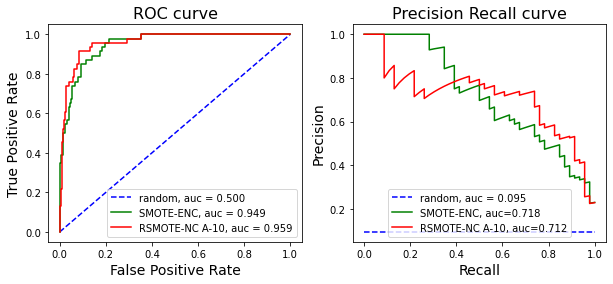

In [46]:
##Create ROC-AUC and PR-AUC curve


dict_models = {"SMOTE-ENC": MODELS / 'ccard_mysmotenc.sav',
                "RSMOTE-NC A-10": MODELS / 'ccard_rsmotenc_ahmadL110.sav'}

#generate_curves(dict_models, X_test, y_test,save = REPORTS / "ccard_roc_prc.jpeg")
generate_curves(dict_models, X_test, y_test)

<Figure size 720x720 with 0 Axes>

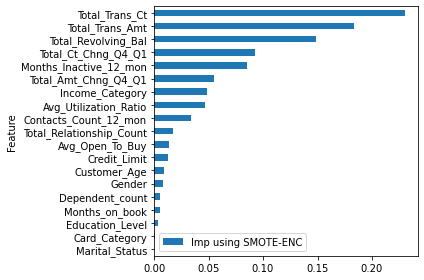

In [43]:
## Find out important features using our new SMOTE-ENC method

filename = (MODELS / 'ccard_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'ccaard_mysmotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

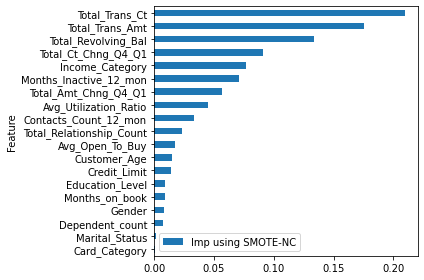

In [40]:
## Find out important features using the existing SMOTE method

filename = (MODELS / 'ccard_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'ccaard_smotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

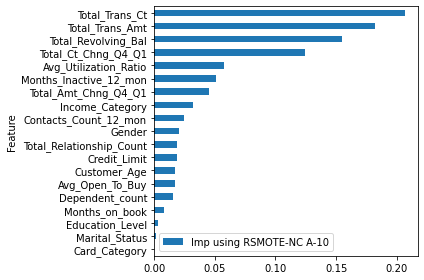

In [42]:
filename = (MODELS / 'ccard_rsmotenc_ahmad10.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using RSMOTE-NC A-10']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'ccaard_rsmotenc_ahmad10.jpeg', bbox_inches='tight')

In [140]:
filename = (MODELS / 'ccard_rsmotenc.sav')
model1 = pickle.load(open(filename, 'rb'))

filename = (MODELS / 'ccard_smotenc.sav')
model2 = pickle.load(open(filename, 'rb'))

for scoring in ('precision', 'precision_micro', 'precision_macro',
                'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 
                'recall_weighted', 'recall_micro'):
    
    cv_scoremodel1 = cross_val_score(model1, X_train, y_train, cv=kfold, scoring = scoring)
    cv_scoremodel2 = cross_val_score(model2, X_train, y_train, cv=kfold, scoring = scoring)
    t, p = stats.ttest_ind(cv_scoremodel1, cv_scoremodel2, equal_var = True)
    print(scoring, t, p)
    
    
    
    

[4 4 5 5 4 5 4 3 4 5 5 5 4 4 5 5 2 5 4 4 2 4 2 3 1 2 4 5 4 4 4 5 2 2 5 4 2
 2 5 5 4 4 4 4 2 4 4 4 3 2 4 5 4 5 4 4 5 5 5 3 3 5 2 5 2 4 3 4 2 5 5 0 2 5
 5 3 4 5 3 4 5 5 4 3 1 3 5 5 4 1 3 4 2 3 2 4 5 2 5 2 4 0 4 3 5 4 4 3 3 4 3
 2 5 2 4 3 5 5 3 0 4 3 3 3 5 4 0 4 5 3 0 5 5 5 5 3 4 5 4 2 3 3 4 4 5 3 4 2
 3 5 4 3 1 5 4 3 2 3 3 3 2 3 2 3 2 5 3 3 2 2 5 4 5 2 2 5 4 5 3 3 2 4 4 4 4
 4 3 2 3 5 5 4 4 2 4 4 4 4 4 2 4 3 5 3 5 5 5 4 5 5 3 5 4 5 5 1 4 4 2 4 5 5
 4 4 5 2 5 1 4 4 5 5 4 4 3 2 4 4 4 2 1 3 2 2 4 4 5 4 3 4 5 5 4 3 3 4 1 2 4
 2 4 5 4 3 5 3 1 1 5 4 3 2 5 5 4 4 4 3 3 2 3 3 5 5 4 4 5 2 4 3 4 3 4 5 5 3
 3 5 5]
[[ 1.         -0.77747087 -0.95464523 ... -1.15663664 -0.69358463
  -1.05791853]
 [ 1.          0.71309772  1.04750955 ... -1.02974327 -1.54356505
   2.06835101]
 [ 1.         -0.65325682 -0.95464523 ... -0.98744548 -0.30383752
  -1.05791853]
 ...
 [ 1.         -0.28061467 -0.95464523 ... -1.19893444 -1.09991673
  -1.05791853]
 [ 1.         -0.90168492  1.04750955 ... -0.94514769  0.770040

In [39]:
idnum = [0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
idbin = []
idcat = [1, 3, 4, 5, 6]

data = encoded_df.to_numpy()

distance_matrices = {"Euclidean": cdist(data.astype(np.float16),data.astype(np.float16)),
                    "Gower" : distmix(data, method = "gower", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Huang" : distmix(data, method = "huang", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 3": distmix(data, method = "ahmad", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 10": distmix(data, method = "ahmad", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat )}

[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  3.6077568531036377
Cat finished
---------------------------
[0, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[]
[1, 3, 4, 5, 6]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
--

In [40]:
np.sum(df_target)

target    160
dtype: int64

0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, ste

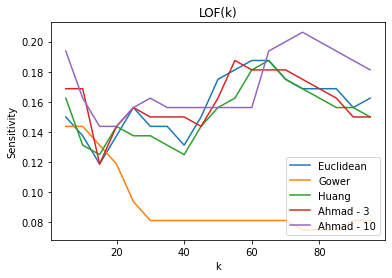

0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, ste

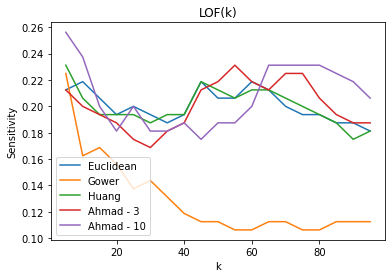

0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, step=1)
Int64Index([3150, 2524, 7073,  545, 7483, 7366, 1477, 9622, 3952, 8521,
            ...
            2608, 6792, 5760, 9442, 1310, 5419, 4742, 1512, 8949, 9250],
           dtype='int64', length=1940)
0
RangeIndex(start=0, stop=1940, ste

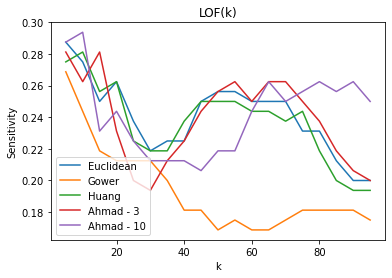

In [41]:
outlier_prevelance = 160
index = encoded_df.index
neigbs = list(range(5,100,5))
metric = "Sensitivity"

test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance, metric, save = REPORTS / "ccard_distances100.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, int(outlier_prevelance*1.5), metric, save = REPORTS / "ccard_distances150.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance*2, metric, save = REPORTS / "ccard_distances200.jpeg")